In [1]:
# print(K.tensorflow_backend._get_available_gpus())
from __future__ import absolute_import, division, print_function, unicode_literals
#
import tensorflow as tf
#import keras.backend.tensorflow_backend as KTF
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device,True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Attention,MaxPool1D,Dense, Conv1D, Convolution2D, GRU, LSTM, Bidirectional, TimeDistributed,
                          Dropout, Flatten, LayerNormalization,RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from tensorflow.keras.models import load_model
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import linear_model
import pandas as pd
import torch
import torch.nn as nn
import random
#from keras import layers as layers
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from scipy import special
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras_self_attention import SeqSelfAttention

In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.decomposition import NMF
from scipy import io
import numpy as np
import os
import os.path

In [78]:
def encode_identity_block(X, stage, block, size, n_step, drop_frac, l1_norm):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'encode' + str(stage) + block + '_branch'
    
    X_shortcut = X
   
    X = layers.Dense(n_step,activation='relu',name=bn_name_base + '2a',activity_regularizer=l1(l1_norm))(X)
    print(X.shape)
    
   # X = layers.BatchNormalization(axis = 1, name = bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    
    X = layers.Dense(n_step,activation='relu',name=bn_name_base + '2b',activity_regularizer=l1(l1_norm))(X)
    
   # X = layers.BatchNormalization(axis = 1, name = bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)
    
    X = layers.Dense(n_step,activation='relu',name=bn_name_base + '2c',activity_regularizer=l1(l1_norm))(X)
    
   # X = layers.BatchNormalization(axis = 1, name = bn_name_base + '2c')(X)
    
    X = layers.add([X, X_shortcut])
    X = LayerNormalization(axis=1 , center=True , scale=True)(X)
    X = layers.Activation('relu')(X)
    
    return X

In [79]:
def decode_identity_block(X, stage, block, size, n_step, drop_frac, l1_norm):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'decode' + str(stage) + block + '_branch'
    
    X_shortcut = X
    X = Attention()([X,X])
    X = layers.add([X,X_shortcut])
    X = LayerNormalization(axis=1 , center=True , scale=True)(X)
    X = layers.Dense(n_step,activation='relu',name=bn_name_base + '2a',activity_regularizer=l1(l1_norm))(X)
    #X = layers.BatchNormalization(axis = 1, name = bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    
    X = layers.Dense(n_step,activation='relu',name=bn_name_base + '2b',activity_regularizer=l1(l1_norm))(X)
    
    #X = layers.BatchNormalization(axis = 1, name = bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)
    
    X = layers.Dense(n_step,activation='relu',name=bn_name_base + '2c',activity_regularizer=l1(l1_norm))(X)
    #X = layers.BatchNormalization(axis = 1, name = bn_name_base + '2c')(X)
    
    X = layers.add([X, X_shortcut])
    X = LayerNormalization(axis=1 , center=True , scale=True)(X)
    X = layers.Activation('relu')(X)
    
    return X

In [80]:
def ResNet50(lr=3e-5, size=128, drop_frac=0, n_step=784, embedding = 16, l1_norm = 1e-5):

    X_input = layers.Input(shape=(n_step,1))
    X = X_input

    X = encode_identity_block(X, 2, 'b', size, n_step, drop_frac, l1_norm)
    X = encode_identity_block(X, 2, 'c', size, n_step, drop_frac, l1_norm)
    X = encode_identity_block(X, 2, 'd', size, n_step, drop_frac, l1_norm)
    
    print(X.shape)
    X = layers.MaxPool1D(pool_size =2 , strides = None, padding = 'valid',data_format = 'channels_first')(X)
    #X = layers.BatchNormalization(axis=1, name='last_encode')(X)
    
    X = layers.Activation('relu')(X)
    X = layers.Dense(embedding,activation='relu',name='embedding_layer',activity_regularizer=l1(l1_norm))(X)
    #X = layers.RepeatVector(n_step)(X)
    
    X = layers.Dense(n_step,activation='relu',name='embedding_layer2',activity_regularizer=l1(l1_norm))(X)
    
    #X = layers.Bidirectional(LSTM(size, return_sequences=True, dropout=drop_frac, 
    #                         activity_regularizer=l1(l1_norm)))(X)
    
    #X = layers.BatchNormalization(axis = 1, name = 'fires_decode')(X)
    X = layers.Activation('relu')(X)

    X = decode_identity_block(X, 2, 'b', size, n_step, drop_frac, l1_norm)
    X = decode_identity_block(X, 2, 'c', size, n_step, drop_frac, l1_norm)
    X = decode_identity_block(X, 2, 'd', size, n_step, drop_frac, l1_norm)
    
    X = layers.BatchNormalization(axis = 1, name = 'batch_normal')(X)
    X = layers.TimeDistributed(Dense(1, activation='linear'))(X)
    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    model.compile(Adam(lr), loss='mse')

    return model

In [81]:
Try = ResNet50()

(None, 784, 784)
(None, 784, 784)
(None, 784, 784)
(None, 784, 784)


In [82]:
Try.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 784, 1)]     0                                            
__________________________________________________________________________________________________
encode2b_branch2a (Dense)       (None, 784, 784)     1568        input_23[0][0]                   
__________________________________________________________________________________________________
activation_296 (Activation)     (None, 784, 784)     0           encode2b_branch2a[0][0]          
__________________________________________________________________________________________________
encode2b_branch2b (Dense)       (None, 784, 784)     615440      activation_296[0][0]             
___________________________________________________________________________________________

In [69]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [83]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [84]:
x_tra = np.atleast_3d(x_train)
x_tes = np.atleast_3d(x_test)

In [85]:
x_tra.shape

(60000, 784, 1)

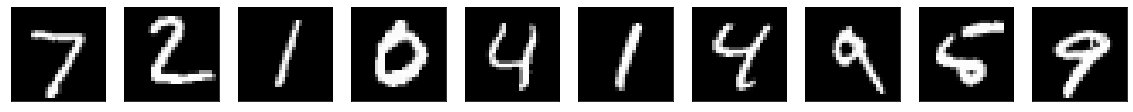

In [73]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#     # display reconstruction
#     ax = plt.subplot(2, n, i + 1 + n)
#     plt.imshow(decoded_imgs[i].reshape(28, 28))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
plt.show()

In [86]:
Try.fit(x_tra, x_tra,
                epochs=500,
                batch_size=256,
                shuffle=True,
                validation_data=(x_tes, x_tes))

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
  512/60000 [..............................] - ETA: 13:40:55 - loss: 12.3085

KeyboardInterrupt: 